In [ ]:
#| default_exp models.deepar

# DeepAR

The DeepAR model produces probabilistic forecasts based on an autoregressive recurrent neural network optimized on panel data using cross-learning. DeepAR obtains its forecast distribution uses a Markov Chain Monte Carlo sampler with the following conditional probability:
$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

where $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.
The predictions are obtained by transforming the hidden states $\mathbf{h}_{t}$ into predictive distribution parameters $\theta_{t}$, and then generating samples $\mathbf{\hat{y}}_{[t+1:t+H]}$ through Monte Carlo sampling trajectories.

$$
\begin{align}
\mathbf{h}_{t} &= \textrm{RNN}([\mathbf{y}_{t},\mathbf{x}^{(f)}_{t+1},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{\theta}_{t}&=\textrm{Linear}(\mathbf{h}_{t}) \\
\hat{y}_{t+1}&=\textrm{sample}(\;\mathrm{P}(y_{t+1}\;|\;\mathbf{\theta}_{t})\;)
\end{align}
$$

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>


:::{.callout-warning collapse="false"}
#### Exogenous Variables, Losses, and Parameters Availability

Given the sampling procedure during inference, DeepAR only supports `DistributionLoss` as training loss.

Note that DeepAR generates a non-parametric forecast distribution using Monte Carlo. We use this sampling procedure also during validation to make it closer to the inference procedure. Therefore, only the `MQLoss` is available for validation.

Aditionally, Monte Carlo implies that historic exogenous variables are not available for the model.
:::

![Figure 1. DeepAR model, during training the optimization signal comes from likelihood of observations, during inference a recurrent multi-step strategy is used to generate predictive distributions.](imgs_models/deepar.jpeg)

In [ ]:
#| export
import torch
import torch.nn as nn

from typing import Optional

from neuralforecast.common._base_model import BaseModel
from neuralforecast.losses.pytorch import DistributionLoss, MAE

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| hide
import logging
import warnings

from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| hide
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
#| export
class Decoder(nn.Module):
    """Multi-Layer Perceptron Decoder

    **Parameters:**<br>
    `in_features`: int, dimension of input.<br>
    `out_features`: int, dimension of output.<br>
    `hidden_size`: int, dimension of hidden layers.<br>
    `num_layers`: int, number of hidden layers.<br>
    """

    def __init__(self, in_features, out_features, hidden_size, hidden_layers):
        super().__init__()

        if hidden_layers == 0:
            # Input layer
            layers = [nn.Linear(in_features=in_features, out_features=out_features)]
        else:
            # Input layer
            layers = [nn.Linear(in_features=in_features, out_features=hidden_size), nn.ReLU()]
            # Hidden layers
            for i in range(hidden_layers - 2):
                layers += [nn.Linear(in_features=hidden_size, out_features=hidden_size), nn.ReLU()]
            # Output layer
            layers += [nn.Linear(in_features=hidden_size, out_features=out_features)]

        # Store in layers as ModuleList
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
#| export
class DeepAR(BaseModel):
    """ DeepAR

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `lstm_n_layers`: int=2, number of LSTM layers.<br>
    `lstm_hidden_size`: int=128, LSTM hidden size.<br>
    `lstm_dropout`: float=0.1, LSTM dropout.<br>
    `decoder_hidden_layers`: int=0, number of decoder MLP hidden layers. Default: 0 for linear layer. <br>
    `decoder_hidden_size`: int=0, decoder MLP hidden size. Default: 0 for linear layer.<br>
    `trajectory_samples`: int=100, number of Monte Carlo trajectories during inference.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>
    - [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
    - [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = True
    MULTIVARIATE = False
    RECURRENT = True

    def __init__(self,
                 h,
                 input_size: int = -1,
                 lstm_n_layers: int = 2,
                 lstm_hidden_size: int = 128,
                 lstm_dropout: float = 0.1,
                 decoder_hidden_layers: int = 0,
                 decoder_hidden_size: int = 0,
                 trajectory_samples: int = 100,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = DistributionLoss(distribution='StudentT', level=[80, 90], return_params=False),
                 valid_loss = MAE(),
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 **trainer_kwargs):

        if exclude_insample_y:
            raise Exception('DeepAR has no possibility for excluding y.')
        
        # Inherit BaseWindows class
        super(DeepAR, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    lr_scheduler=lr_scheduler,
                                    lr_scheduler_kwargs=lr_scheduler_kwargs,
                                    **trainer_kwargs)

        self.n_samples = trajectory_samples

        # LSTM
        self.encoder_n_layers = lstm_n_layers
        self.encoder_hidden_size = lstm_hidden_size
        self.encoder_dropout = lstm_dropout
       
        # LSTM input size (1 for target variable y)
        input_encoder = 1 + self.futr_exog_size + self.stat_exog_size

        # Instantiate model
        self.rnn_state = None
        self.hist_encoder = nn.LSTM(input_size=input_encoder,
                                    hidden_size=self.encoder_hidden_size,
                                    num_layers=self.encoder_n_layers,
                                    dropout=self.encoder_dropout,
                                    batch_first=True)

        # Decoder MLP
        self.decoder = Decoder(in_features=lstm_hidden_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=decoder_hidden_size,
                               hidden_layers=decoder_hidden_layers)

    def forward(self, windows_batch):

        # Parse windows_batch
        encoder_input = windows_batch['insample_y'] # <- [B,T,1]
        futr_exog  = windows_batch['futr_exog']
        stat_exog  = windows_batch['stat_exog']

        _, input_size = encoder_input.shape[:2]
        if self.futr_exog_size > 0:
            encoder_input = torch.cat((encoder_input, futr_exog), dim=2)

        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, input_size, 1) # [B, S] -> [B, input_size-1, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)

        # RNN forward
        if self.maintain_state:
            rnn_state = self.rnn_state
        else:
            rnn_state = None

        hidden_state, rnn_state = self.hist_encoder(encoder_input, 
                                                    rnn_state) # [B, input_size-1, rnn_hidden_state]

        if self.maintain_state:
            self.rnn_state = rnn_state

        # Decoder forward
        output = self.decoder(hidden_state) # [B, input_size-1, output_size]

        # Return only horizon part
        return output[:, -self.h:]

In [ ]:
show_doc(DeepAR, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/deepar.py#L54){target="_blank" style="float:right; font-size:smaller"}

### DeepAR

>      DeepAR (h, input_size:int=-1, lstm_n_layers:int=2,
>              lstm_hidden_size:int=128, lstm_dropout:float=0.1,
>              decoder_hidden_layers:int=0, decoder_hidden_size:int=0,
>              trajectory_samples:int=100, futr_exog_list=None,
>              hist_exog_list=None, stat_exog_list=None,
>              exclude_insample_y=False, loss=DistributionLoss(),
>              valid_loss=MAE(), max_steps:int=1000, learning_rate:float=0.001,
>              num_lr_decays:int=3, early_stop_patience_steps:int=-1,
>              val_check_steps:int=100, batch_size:int=32,
>              valid_batch_size:Optional[int]=None, windows_batch_size:int=1024,
>              inference_windows_batch_size:int=-1, start_padding_enabled=False,
>              step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>              num_workers_loader=0, drop_last_loader=False, optimizer=None,
>              optimizer_kwargs=None, lr_scheduler=None,
>              lr_scheduler_kwargs=None, **trainer_kwargs)

*DeepAR

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`lstm_n_layers`: int=2, number of LSTM layers.<br>
`lstm_hidden_size`: int=128, LSTM hidden size.<br>
`lstm_dropout`: float=0.1, LSTM dropout.<br>
`decoder_hidden_layers`: int=0, number of decoder MLP hidden layers. Default: 0 for linear layer. <br>
`decoder_hidden_size`: int=0, decoder MLP hidden size. Default: 0 for linear layer.<br>
`trajectory_samples`: int=100, number of Monte Carlo trajectories during inference.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>*

In [ ]:
show_doc(DeepAR.fit, name='DeepAR.fit', title_level=3)

---

### DeepAR.fit

>      DeepAR.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                  distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(DeepAR.predict, name='DeepAR.predict', title_level=3)

---

### DeepAR.predict

>      DeepAR.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                      **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

## Usage Example

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.02it/s]


[]

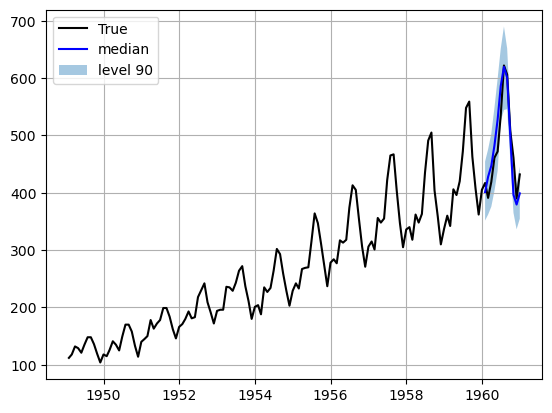

In [ ]:
#| eval: false
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
#from neuralforecast.models import DeepAR
from neuralforecast.losses.pytorch import DistributionLoss, HuberMQLoss, MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

#AirPassengersPanel['y'] = AirPassengersPanel['y'] + 10
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[DeepAR(h=12,
                   input_size=24,
                   lstm_n_layers=1,
                   trajectory_samples=100,
                   loss=DistributionLoss(distribution='Normal', level=[80, 90], return_params=False),
                #    loss=MQLoss(level=[10, 20, 30, 40, 50, 60, 70, 80, 90]),
                #    loss = MAE(),
                #    valid_loss = MAE(),
                   learning_rate=0.005,
                   stat_exog_list=['airline1'],
                   futr_exog_list=['trend'],
                   max_steps=50,
                   val_check_steps=10,
                   early_stop_patience_steps=-1,
                   scaler_type='standard',
                   enable_progress_bar=True,
                #    step_size=1,
                #    inference_input_size=12,
                   ),
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
# plt.plot(plot_df['ds'], plot_df['DeepAR'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['DeepAR-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['DeepAR-lo-90'][-12:].values, 
                 y2=plot_df['DeepAR-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()